# Slippage Modeling Analysis

This notebook explores the temporary market impact function $g_t(x)$ across three stocks: FROG, SOUN, and CRWV. We compute slippage over varying order volumes, fit linear and quadratic models, and evaluate model performance using $R^2$.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

# Load order book snapshots
df = pd.read_csv("/Users/ishitashah/Desktop/Projects/Blockhouse/all_minute_order_book_snapshots.csv")

# Drop rows with missing LOB data
df.dropna(subset=[f'ask_px_0{i}' for i in range(10)] + [f'ask_sz_0{i}' for i in range(10)], inplace=True)
df = df.reset_index(drop=True)


## Slippage Simulation Function

In [2]:
def compute_slippage(x, ask_prices, ask_sizes, mid_price):
    cost, remaining = 0, x
    for price, size in zip(ask_prices, ask_sizes):
        take = min(size, remaining)
        cost += take * price
        remaining -= take
        if remaining <= 0:
            break
    return np.nan if remaining > 0 else (cost / x) - mid_price


## Fit Linear and Quadratic Models for One Snapshot

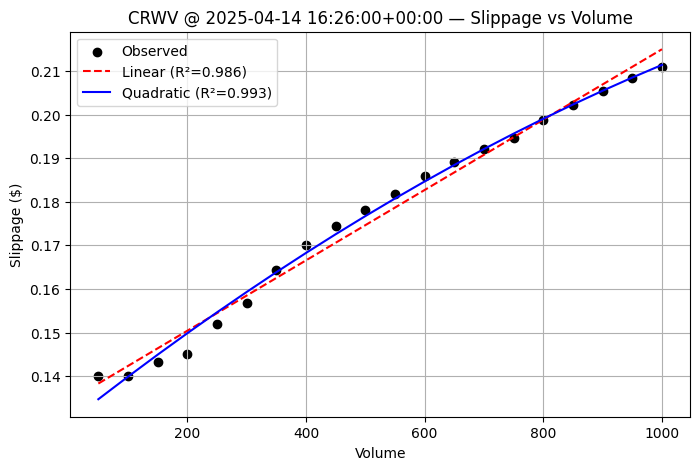

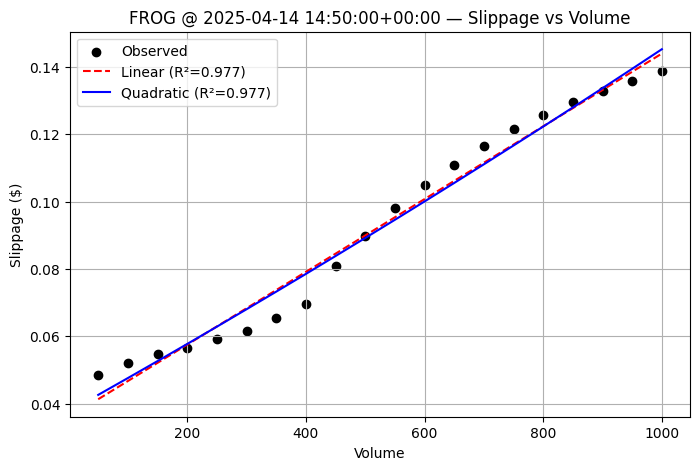

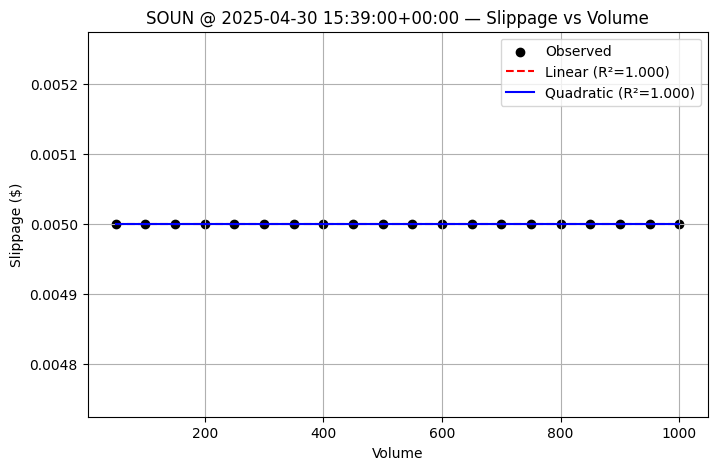

In [4]:
samples = df.groupby('stock').sample(n=1, random_state=42)
for _, snapshot in samples.iterrows():
    volumes = np.arange(50, 1050, 50).reshape(-1, 1)
    
    ask_prices = [snapshot[f'ask_px_0{i}'] for i in range(10)]
    ask_sizes = [snapshot[f'ask_sz_0{i}'] for i in range(10)]
    bid = snapshot['bid_px_00'] if pd.notna(snapshot['bid_px_00']) else ask_prices[0] - 0.05
    ask = ask_prices[0]
    mid_price = (bid + ask) / 2

    y = np.array([compute_slippage(x[0], ask_prices, ask_sizes, mid_price) for x in volumes])
    mask = ~np.isnan(y)
    X = volumes[mask]
    y = y[mask]

    # Linear fit
    lin_model = LinearRegression().fit(X, y)
    y_lin = lin_model.predict(X)
    r2_lin = r2_score(y, y_lin)

    # Quadratic fit
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    quad_model = LinearRegression().fit(X_poly, y)
    y_quad = quad_model.predict(X_poly)
    r2_quad = r2_score(y, y_quad)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(X, y, color='black', label='Observed')
    plt.plot(X, y_lin, 'r--', label=f'Linear (R²={r2_lin:.3f})')
    plt.plot(X, y_quad, 'b-', label=f'Quadratic (R²={r2_quad:.3f})')
    plt.title(f"{snapshot['stock']} @ {snapshot['minute']} — Slippage vs Volume")
    plt.xlabel("Volume")
    plt.ylabel("Slippage ($)")
    plt.legend()
    plt.grid(True)
    plt.show()


## Next Steps

- Scale up this fitting across multiple timestamps
- Compare $R^2$ distributions for each model and stock
- Summarize model preference based on fit quality